In [1]:
import os

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from graspy.utils import import_graph, pass_to_ranks
from graspy.embed import OmnibusEmbed, ClassicalMDS
from graspy.embed.svd import select_dimension
from graspy.cluster import GaussianCluster
from graspy.plot import heatmap, pairplot

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/j1c/graphstats/venv/lib/python3.6/site-packages/graspy/plot/__init__.py:8: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


### Loading and handling the data

In [2]:
def import_edgelist(path, nodetype=int, delimiter=None):
    """
    Function for reading an edgelist and returning a numpy array.
    The order of nodes are sorted by node values.

    Parameters
    ----------
    path : str
    delimiter : str, optional
    
    Returns
    -------
    graph : array-like, shape (n_vertices, n_vertices)
        Adjacency matrix of the graph created from edgelist.
    """
    G = nx.read_weighted_edgelist(path, delimiter=delimiter, nodetype=nodetype)
    graph = nx.to_numpy_array(G, nodelist=sorted(G.nodes), dtype=np.float)

    return import_graph(graph)

In [3]:
df = pd.read_csv('./subject_information.csv')
sex_labels = df['Sex'].values

In [4]:
fmri_path = '../HBN/fmri/desikan/'
fmris = os.listdir(fmri_path)

dmri_path = '../HBN/dwi/desikan/'
dmris = os.listdir(dmri_path)

dmri_graphs = []
fmri_graphs = []

for subject in df['Patient_ID'].values:
    dfile = [i for i in dmris if subject in i][0]
    ffile = [i for i in fmris if subject in i][0]
    dmri_graphs.append(import_edgelist(dmri_path + dfile))
    fmri_graphs.append(import_edgelist(fmri_path + ffile))

In [5]:
print(len(fmri_graphs), len(dmri_graphs))

289 289


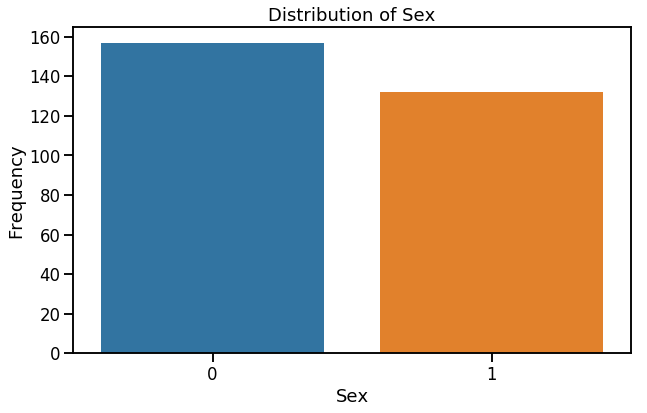

In [6]:
with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.barplot(x=[0, 1], y= np.bincount(sex_labels))
    plot.set(xlabel='Sex', ylabel='Frequency', title='Distribution of Sex')

# Multimodal, multigraph clustering

## Embedding the multimodal graphs all at once

Data summary
- subjects = 30
- total fmri scans = 289
- total dmri scans = 289
- total scans = 578

Desikan atlas
- num vertices = 70

## KMeans on vectorized data as baseline

1. vectorize the upper triangle for both fmris and dmris
2. concatenate the fmri and dmri vectors for each subject
3. results in matrix in $\mathbb{R}^{289 \times 4970}$
4. run kmeans on the matrix with varying $k$ and compute ARI

In [7]:
idx = np.triu_indices(70)

fmri_vecs = np.vstack([g[idx] for g in fmri_graphs])
dmri_vecs = np.vstack([g[idx] for g in dmri_graphs])
mri_vectors = np.hstack([fmri_vecs, dmri_vecs])

mri_vectors.shape

(289, 4970)

### ARI shows no meaningful clusters in sex

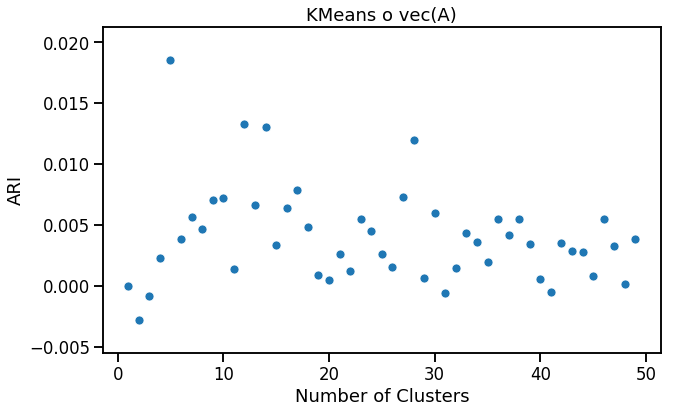

In [22]:
aris = []

for n_clusters in range(1, 50):
    kmeans = KMeans(n_clusters=n_clusters)
    predictions = kmeans.fit_predict(mri_vectors)
    aris.append(adjusted_rand_score(sex_labels, predictions))

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='KMeans o vec(A)')

## Try with GClust o CMDS o Omni

## Embedding the multimodal graphs all at once and concatenating results from fMRI and DWIs

First we embed graphs from DWIs and fMRIs separately. Then we concatenate the resulting estimated latent position vectors

In [9]:
fmri_graphs = [pass_to_ranks(f) for f in fmri_graphs]
dmri_graphs = [pass_to_ranks(f) for f in dmri_graphs]

In [10]:
omni = OmnibusEmbed(n_elbows=2)
dmri_hat = omni.fit_transform(dmri_graphs)

omni = OmnibusEmbed(n_elbows=2)
fmri_hat = omni.fit_transform(fmri_graphs)

Z_hat = np.hstack([fmri_hat, dmri_hat])
Z_hat.shape

(20230, 7)

In [11]:
Z_hat = Z_hat.reshape((289, 70, -1))
Z_hat.shape

(289, 70, 7)

In [12]:
cmds = ClassicalMDS(n_components=5)
X = cmds.fit_transform(Z_hat)

In [13]:
dissimilarity = cmds.dissimilarity_matrix_

### T-semipar shows block structure based on subjects

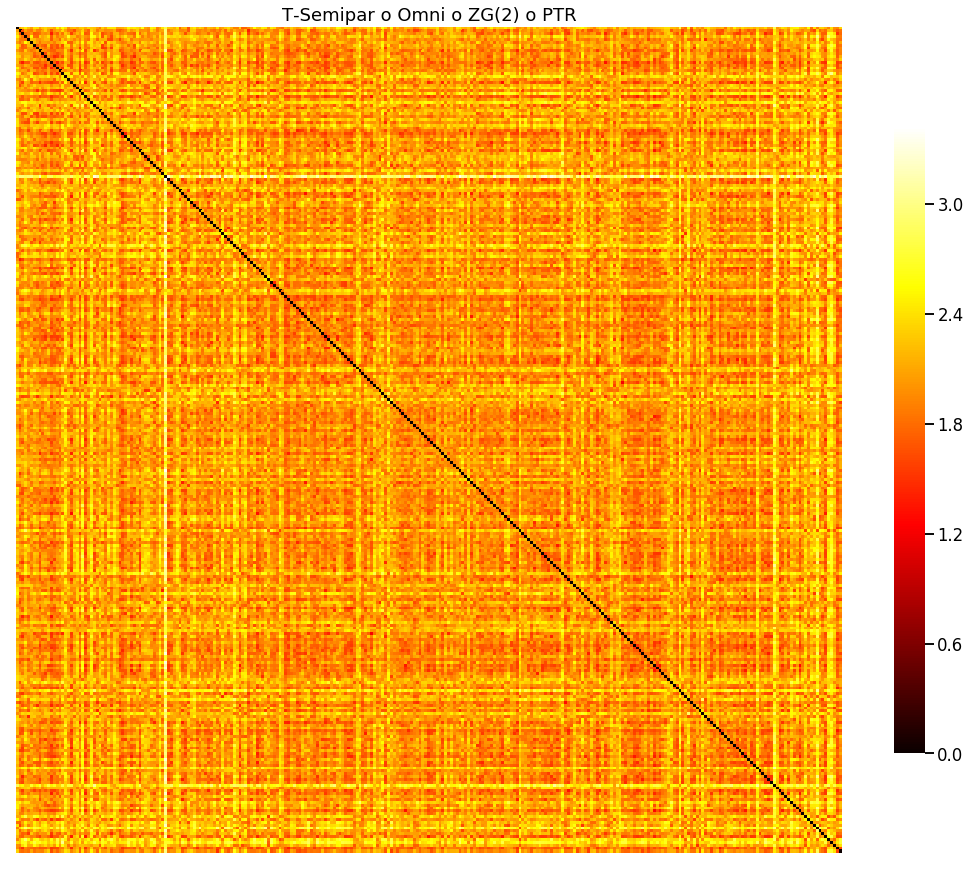

In [14]:
figsize=(15, 13)
title = 'T-Semipar o Omni o ZG(2) o PTR'
semipar = heatmap(dissimilarity, figsize=figsize, title=title, cmap='hot')

### cMDS o T-Semipar o Omni o PTR

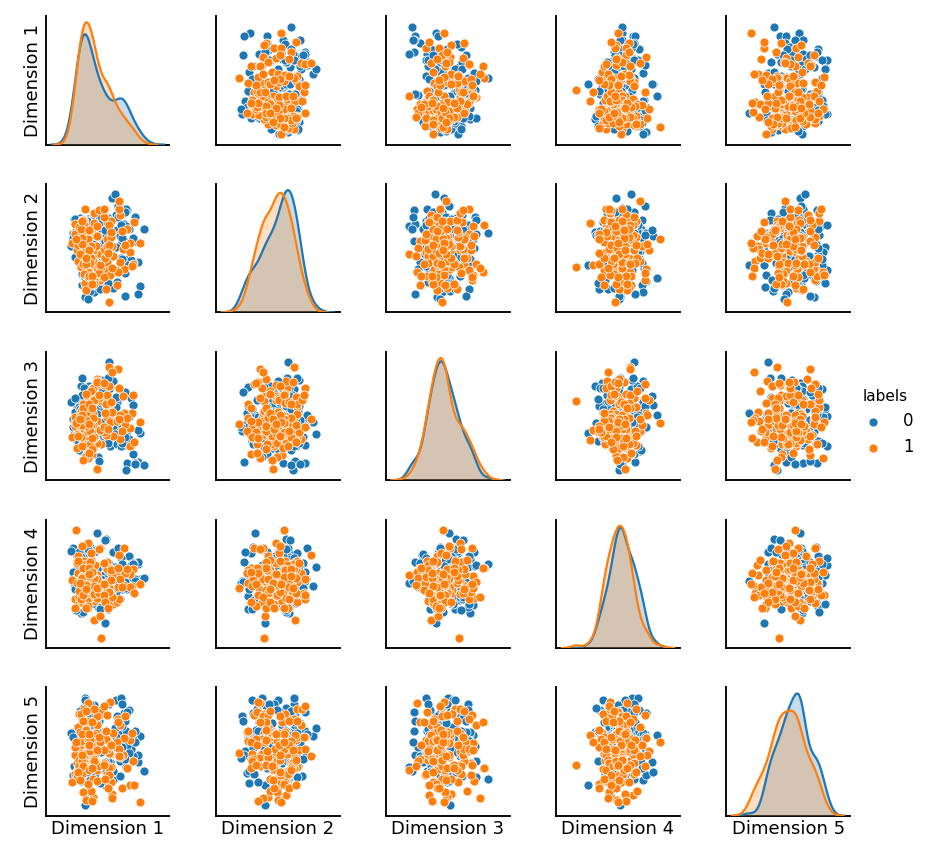

In [15]:
pairplot(np.fliplr(X), labels=sex_labels)

### BIC is minimized when num_clusters=2, but ARI suggests no meaningful clusters were found

There are 2 unique labels, each corresponding to sex.

In [16]:
gclust = GaussianCluster(max_components = 50)
gclust.fit(X, sex_labels)

GaussianCluster(covariance_type='full', max_components=50, random_state=None)

1424.6678125336603 2


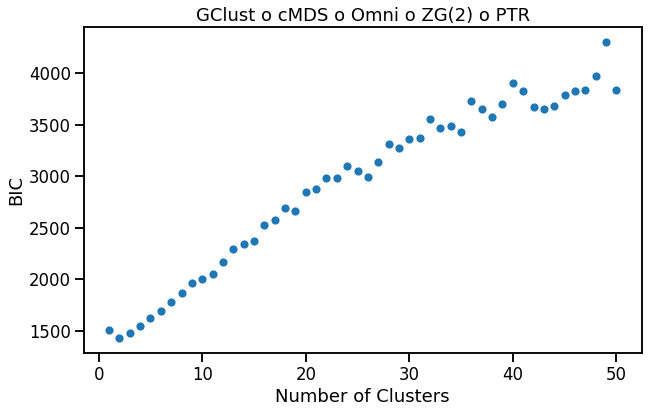

In [17]:
bics = gclust.bic_
print(np.min(bics), np.argmin(bics) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(bics) + 1), bics)
    plot.set(xlabel='Number of Clusters', ylabel='BIC', title='GClust o cMDS o Omni o ZG(2) o PTR')

0.008689105909722898 7


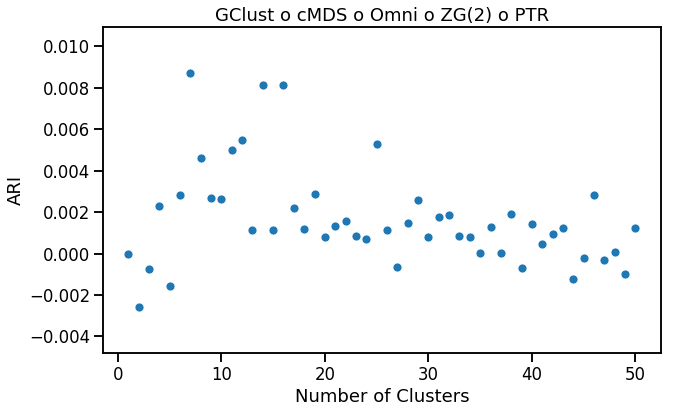

In [18]:
aris = gclust.ari_
print(np.max(aris), np.argmax(aris) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='GClust o cMDS o Omni o ZG(2) o PTR')